### In this notebook we will implement Simple Lane Detection on video file. This problem is used in self-driving cars. And it is the essence of computer vision.

### Solving an Easier Problem

First of all, one obvious way to make the problem easier is to work out our solution for a single image. A video is, after all, just a series of images. We can then move on to running our pipeline on an input video frame-by-frame as a final solution to the original problem of processing an entire video for lane detection.
For example, let’s take the single image frame below.

<img src="images/road_lane.jpg">

In the above image, the lane markers are obvious to any human observer. We perform processing of this image intuitively, and after being trained to drive a human can detect the lane in which the vehicle appears to be moving. Humans also effortlessly identify many other objects in the scene, such as the other vehicles, the embankment near the right shoulder, some road signs alongside the road, and even the mountains visible on the horizon. While many of these objects are complex in visual structure, it could be said that the lane markers are actually some of the simplest structures in the image!

Pre-existing knowledge of driving gives us certain assumptions about the properties and structure of a lane, further simplifying the problem. One obvious assumption is that the lane is oriented to be parallel with the direction of movement. This being the case, the lines denoting the lane will tend to extend from the foreground of an image into the background along paths that are angled slightly inwards. We can also assume that the lines will never quite reach the horizon, either disappearing with distance or being obscured by some other image feature along the way.

One very simple filter on the image could be to crop out all of the areas which we believe will never contain information about the lane markers. We’ll kick off our project by writing the code necessary to do a simple crop of the region of interest.

### Cropping to a Region of Interest

#### Loading an Image into Memory

This image is: <class 'numpy.ndarray'> with dimensions: (571, 1000, 3)


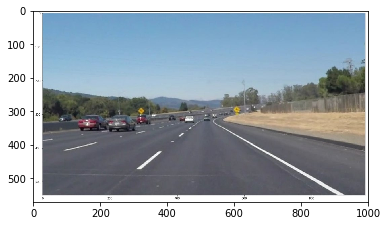

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# reading in an image
image = mpimg.imread('images/road_lane.jpg')
# printing out some stats and plotting the image
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)
plt.show()

#### Defining the Region of Interest

If you have worked with computer graphics before (or even if you paid close attention to the plotted image above!), you realize that the point (0, 0) (the origin) is actually in the upper left corner of the image. This is not exactly intuitive for most people, because general mathematics education tends to only show coordinate systems starting with the origin in the bottom left corner. That being said, this will not cause a lot of complications at this stage aside from the fact that the y coordinates of our region of interest will be specified by their distance from the top of the image rather than from the bottom.

We want a region of interest that fully contains the lane lines. One simple shape that will achieve this goal is a triangle that begins at the bottom left corner of the image, proceeds to the center of the image at the horizon, and then follows another edge to the bottom right corner of the image. Those vertices are defined as follows:

In [3]:
height, width = image.shape[0], image.shape[1]

region_of_interest_vertices = [
    (0, height),
    (width / 2, height / 2),
    (width, height),
]

#### Cropping the Region of Interest

In [4]:
import numpy as np
import cv2
def region_of_interest(img, vertices):
    # Define a blank matrix that matches the image height/width.
    mask = np.zeros_like(img)
    # Retrieve the number of color channels of the image.
    channel_count = img.shape[2]
    # Create a match color with the same color channel counts.
    match_mask_color = (255,) * channel_count
      
    # Fill inside the polygon
    cv2.fillPoly(mask, vertices, match_mask_color)
    
    # Returning the image only where mask pixels match
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

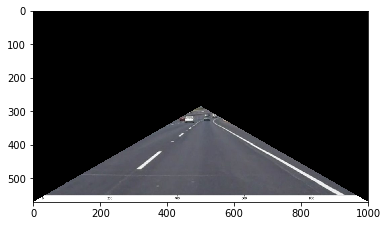

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
region_of_interest_vertices = [
    (0, height),
    (width / 2, height / 2),
    (width, height),
]
image = mpimg.imread('images/road_lane.jpg')
cropped_image = region_of_interest(
    image,
    np.array([region_of_interest_vertices], np.int32),
)
plt.figure()
plt.imshow(cropped_image)
plt.show()

#### Detecting Edges in the Cropped Image

The next part of our pipeline will be detecting shape edges in the remaining (cropped) image data.

It is fairly intuitive to conclude that edges are simply the areas of an image where the color values change very quickly. Therefore, detecting edges in an image becomes a mathematics problem of detecting any area where a pixel is a mismatch in color to all of its neighbors.

**Canny Edge Detection** essentially detects areas of the image that have a strong gradient in the image’s color function. Canny also adds a pair of intensity threshold parameters which indicate generally how strong an edge must be to be detected.

#### Grayscale Conversion and Canny Edge Detection

We don’t actually care about the colors of the picture at all, just the differences between their intensity values. In order to make the edge detection process simpler, we can convert the image into grayscale. This will remove color information and replace it with a single intensity value for each pixel of the image. Now our solution is to use Canny Edge Detection to find areas of the image that rapidly change over the intensity value.

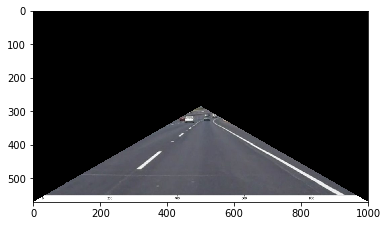

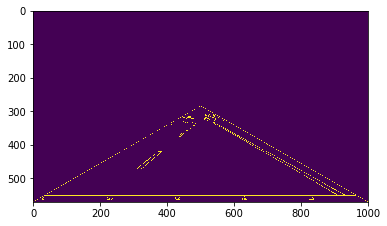

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    channel_count = img.shape[2]
    match_mask_color = (255,) * channel_count
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
region_of_interest_vertices = [
    (0, height),
    (width / 2, height / 2),
    (width, height),
]
image = mpimg.imread('images/road_lane.jpg')
cropped_image = region_of_interest(
    image,
    np.array([region_of_interest_vertices], np.int32),
)
plt.figure()
plt.imshow(cropped_image)
# Convert to grayscale here.
gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)
# Call Canny Edge Detection here.
cannyed_image = cv2.Canny(gray_image, 100, 200)
plt.figure()
plt.imshow(cannyed_image)
plt.show()

We did it!, the image now contains only the single pixels which are indicative of an edge. But there’s a problem… We accidentally detected the edges of our cropped region of interest!

Not to worry, we can fix this problem by simply place the region of interest cropping after the Canny process in our pipeline. We also need to adjust the region of interest utility function to account for the fact that our image is now grayscale:

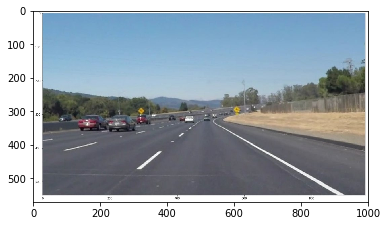

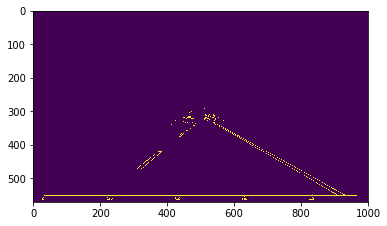

In [8]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255 # <-- This line altered for grayscale.
    
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

region_of_interest_vertices = [
    (0, height),
    (width / 2, height / 2),
    (width, height),
]

image = mpimg.imread('images/road_lane.jpg')
plt.figure()
plt.imshow(image)
plt.show()
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
cannyed_image = cv2.Canny(gray_image, 100, 200)
# Moved the cropping operation to the end of the pipeline.
cropped_image = region_of_interest(
    cannyed_image,
    np.array([region_of_interest_vertices], np.int32)
)
plt.figure()
plt.imshow(cropped_image)
plt.show()

#### Generating Lines from Edge Pixels

If we pay close attention to a region that appears to be a line, we find that the edge pixels have something in common. We can imagine all the possible lines that pass through each pixel, but the points share only a few lines in common. These common lines can be thought of as candidates for the actual line (if it exists) that passes through all of the nearby edge pixels.

<img src="images/lane_detection.png">

The main concept we will be using here is called a **Hough Transform**. Using a Hough Transform, we will transform all of our edge pixels into a different mathematical form. Once the transformation is complete, each edge pixel in “Image Space” will have become a line or curve in “Hough Space”. In Hough Space, each line represents a point from Image Space, and each point represents a line from Image Space.

<img src="images/hough_space.png">

#### Using Hough Transforms to Detect Lines

In [9]:
# image = mpimg.imread('solidWhiteCurve.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
cannyed_image = cv2.Canny(gray_image, 200, 300)
cropped_image = region_of_interest(
    cannyed_image,
    np.array(
        [region_of_interest_vertices],
        np.int32
    ),
)
lines = cv2.HoughLinesP(
    cropped_image,
    rho=6,
    theta=np.pi / 60,
    threshold=160,
    lines=np.array([]),
    minLineLength=40,
    maxLineGap=25
)
print(lines)

[[[ 34 551 966 551]]

 [[520 321 647 394]]

 [[519 324 910 549]]

 [[825 490 926 548]]

 [[860 509 928 548]]

 [[761 456 805 479]]

 [[671 407 737 441]]

 [[418 392 488 336]]

 [[343 456 383 420]]]


Each line is represented by four numbers, which are the two endpoints of the detected line segment, like so [x1, y1, x2, y2]

#### Rendering Detected Hough Lines as an Overlay

The last thing we will do with line detection is render the detected lines back onto the image itself, to give us a sense of the real features in the scene which are being detected. For this rendering, we’ll need to write another utility function:

In [25]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    # If there are no lines to draw, exit.
    if lines is None:
        return
    # Make a copy of the original image.
    img = np.copy(img)
    # Create a blank image that matches the original in size.
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8,
    )
    # Loop over all lines and draw them on the blank image.
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)
    # Merge the image with the lines onto the original.
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
    # Return the modified image.
    return img

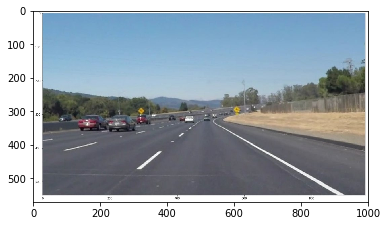

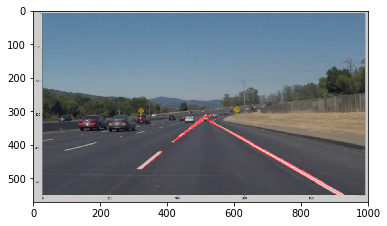

In [13]:
plt.figure()
plt.imshow(image)
plt.show()
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
cannyed_image = cv2.Canny(gray_image, 100, 200)
cropped_image = region_of_interest(
    cannyed_image,
    np.array(
        [region_of_interest_vertices],
        np.int32
    ),
)
lines = cv2.HoughLinesP(
    cropped_image,
    rho=6,
    theta=np.pi / 60,
    threshold=160,
    lines=np.array([]),
    minLineLength=40,
    maxLineGap=25
)
line_image = draw_lines(image, lines) # <---- Add this call.
plt.figure()
plt.imshow(line_image)
plt.show()

Awesome! Now we have a copy of the original with the detected lines rendered as an overlay. This is very cool, but we want to distinguish the left and right lane lines independently and show a single line for each. In the next section, we’ll create a single line for each group of detected lane markings.

#### Creating a Single Left and Right Lane Line

The final step in our pipeline will be to create only one line for each of the groups of lines we found in the last step. This can be done by fitting a simple linear model to the various endpoints of the line segments in each group, then rendering a single overlay line on that linear model.

#### Grouping the Lines into Left and Right Groups

First, though, we need to determine which lines are in the left group, and which are in the right group.

Most importantly, the direction of a line’s slope describes whether the line is moving up or down as you travel along the line from left to right. A line with negative slope is said to be traveling downwards, while a line with positive slope is said to be traveling upwards. This is how slope direction works in normal coordinate systems where the origin is at the bottom left corner. In our coordinate system, however, the origin is in the top left corner, and so our slope directions will be reversed, with negative slopes traveling upwards and positive slopes traveling downwards.

In our images, the left lane markings all have a negative slope, meaning the lines travel upwards towards the horizon as we move from left to right along the lines. On the other hand, all of our right lane markings have a positive slope, traveling downwards towards the bottom of the image as we move along them from left to right. This will be the distinction we use to group the left and right lines.

In [14]:
left_line_x = []
left_line_y = []
right_line_x = []
right_line_y = []
for line in lines:
    for x1, y1, x2, y2 in line:
        slope = (y2 - y1) / (x2 - x1) # <-- Calculating the slope.
        if math.fabs(slope) < 0.5: # <-- Only consider extreme slope
            continue
        if slope <= 0: # <-- If the slope is negative, left group.
            left_line_x.extend([x1, x2])
            left_line_y.extend([y1, y2])
        else: # <-- Otherwise, right group.
            right_line_x.extend([x1, x2])
            right_line_y.extend([y1, y2])

In order to find the correct x values for the top and bottom points of each line, we can develop two functions f(y) = x that define the left and right lines. Then we can feed the two common y values into the functions to find the x values that complete our endpoint coordinates. This function needs to be a linear fit to the coordinates in each group in order to average our detected lines, and fortunately numpy provides some functions to do it!

The **polyfit** and **poly1d** operations can generate a linear function that match the two given spaces (x and y) for each group.

In [16]:
min_y = image.shape[0] * (3 / 5) # <-- Just below the horizon
max_y = image.shape[0] # <-- The bottom of the image

In [17]:
poly_left = np.poly1d(np.polyfit(
    left_line_y,
    left_line_x,
    deg=1
))
left_x_start = int(poly_left(max_y))
left_x_end = int(poly_left(min_y))
poly_right = np.poly1d(np.polyfit(
    right_line_y,
    right_line_x,
    deg=1
))
right_x_start = int(poly_right(max_y))
right_x_end = int(poly_right(min_y))

Now we can use these lines as our input to the draw_lines function in our pipeline:

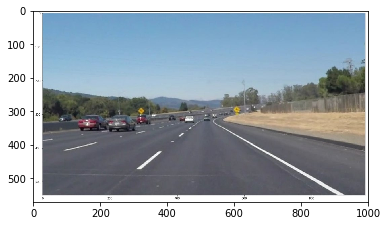

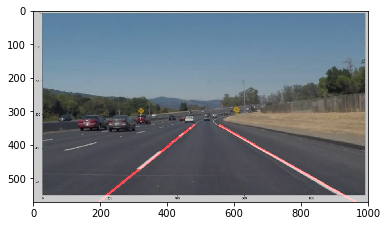

In [29]:
plt.figure()
plt.imshow(image)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
cannyed_image = cv2.Canny(gray_image, 100, 200)
cropped_image = region_of_interest(
    cannyed_image,
    np.array(
        [region_of_interest_vertices],
        np.int32
    ),
)
lines = cv2.HoughLinesP(
    cropped_image,
    rho=6,
    theta=np.pi / 60,
    threshold=160,
    lines=np.array([]),
    minLineLength=40,
    maxLineGap=25
)
left_line_x = []
left_line_y = []
right_line_x = []
right_line_y = []
for line in lines:
    for x1, y1, x2, y2 in line:
        slope = (y2 - y1) / (x2 - x1) # <-- Calculating the slope.
        if math.fabs(slope) < 0.5: # <-- Only consider extreme slope
            continue
        if slope <= 0: # <-- If the slope is negative, left group.
            left_line_x.extend([x1, x2])
            left_line_y.extend([y1, y2])
        else: # <-- Otherwise, right group.
            right_line_x.extend([x1, x2])
            right_line_y.extend([y1, y2])
min_y = image.shape[0] * (3 / 5) # <-- Just below the horizon
max_y = image.shape[0] # <-- The bottom of the image
poly_left = np.poly1d(np.polyfit(
    left_line_y,
    left_line_x,
    deg=1
))
left_x_start = int(poly_left(max_y))
left_x_end = int(poly_left(min_y))
poly_right = np.poly1d(np.polyfit(
    right_line_y,
    right_line_x,
    deg=1
))
right_x_start = int(poly_right(max_y))
right_x_end = int(poly_right(min_y))
line_image = draw_lines(
    image,
    [[
        [left_x_start, max_y, left_x_end, min_y],
        [right_x_start, max_y, right_x_end, min_y],
    ]],
   thickness=5
)
plt.figure()
plt.imshow(line_image)
plt.show()

### Level Up: Annotate a Video

Now that we have an image processing pipeline to work with, we can actually apply the same techniques to a video to overlay our lane lines upon the video!

First, let’s put all of our current work into a defined function named pipeline().

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    # If there are no lines to draw, exit.
    if lines is None:
        return
    # Make a copy of the original image.
    img = np.copy(img)
    # Create a blank image that matches the original in size.
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8,
    )
    # Loop over all lines and draw them on the blank image.
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)
    # Merge the image with the lines onto the original.
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
    # Return the modified image.
    return img

def pipeline(image):
    """
    An image processing pipeline which will output
    an image with the lane lines annotated.
    """
    height = image.shape[0]
    width = image.shape[1]
    region_of_interest_vertices = [
        (0, height),
        (width / 2, height / 2),
        (width, height),
    ]
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    cannyed_image = cv2.Canny(gray_image, 100, 200)
 
    cropped_image = region_of_interest(
        cannyed_image,
        np.array(
            [region_of_interest_vertices],
            np.int32
        ),
    )
 
    lines = cv2.HoughLinesP(
        cropped_image,
        rho=6,
        theta=np.pi / 60,
        threshold=160,
        lines=np.array([]),
        minLineLength=40,
        maxLineGap=25
    )
 
    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []
 
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1) # <-- Calculating the slope.
            if math.fabs(slope) < 0.5: # <-- Only consider extreme slope
                continue
            if slope <= 0: # <-- If the slope is negative, left group.
                left_line_x.extend([x1, x2])
                left_line_y.extend([y1, y2])
            else: # <-- Otherwise, right group.
                right_line_x.extend([x1, x2])
                right_line_y.extend([y1, y2])
    min_y = int(image.shape[0] * (3 / 5))
    max_y = int(image.shape[0])
    poly_left = np.poly1d(np.polyfit(
        left_line_y,
        left_line_x,
        deg=1
    ))
 
    left_x_start = int(poly_left(max_y))
    left_x_end = int(poly_left(min_y))
 
    poly_right = np.poly1d(np.polyfit(
        right_line_y,
        right_line_x,
       deg=1
    ))
 
    right_x_start = int(poly_right(max_y))
    right_x_end = int(poly_right(min_y))
    line_image = draw_lines(
        image,
        [[
            [left_x_start, max_y, left_x_end, min_y],
            [right_x_start, max_y, right_x_end, min_y],
        ]],
        thickness=5,
    )
    return line_image

And then we can write a video processing pipeline:

In [31]:
# !pip3 install moviepy

  Running setup.py install for proglog: started
    Running setup.py install for proglog: finished with status 'done'
  Running setup.py install for moviepy: started
    Running setup.py install for moviepy: finished with status 'done'


You are using pip version 9.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [35]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'videos/lane_detection_output.mp4'
clip1 = VideoFileClip("videos/lane_detection_input.mp4")
white_clip = clip1.fl_image(pipeline)
white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video videos/lane_detection_output.mp4.
Moviepy - Writing video videos/lane_detection_output.mp4



Moviepy - Done !
Moviepy - video ready videos/lane_detection_output.mp4


### Final words

So we've done Simple Lane Detection on Road. <br>
For more information and additional resources please refer to https://medium.com/@mrhwick/simple-lane-detection-with-opencv-bfeb6ae54ec0